# Analysis

This notebook compiles the results of the experiments. The data was logged in MLFlow. For more infromation, check "http://93.125.49.123:49998".

In [1]:
import os
import mlflow
import dotenv
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

mlflow_client = mlflow.MlflowClient()
dotenv.load_dotenv()
mlflow.set_experiment(os.environ["MLFLOW_EXPERIMENT"])

<Experiment: artifact_location='mlflow-artifacts:/348908674542056884', creation_time=1749723965030, experiment_id='348908674542056884', last_update_time=1749723965030, lifecycle_stage='active', name='ifortex_test_task', tags={}>

In [72]:
runs_df = mlflow.search_runs()

def load_metric_history(run_id: str, metric_name: str):
    history = mlflow_client.get_metric_history(run_id, metric_name)
    return [h.value for h in history]

def load_metrics_history(run_id: str):
    metrics = ["BCE_train", "BCE_test", "AUC_train", "AUC_test"]
    return {
        m: load_metric_history(run_id=run_id, metric_name=m)
        for m in metrics
    }

def load_run_as_df(run_id):
    params = mlflow_client.get_run(run_id).data.params
    metrics_history = load_metrics_history(run_id=run_id)
    return pd.DataFrame(metrics_history | params)

def load_runs_as_df(runs_id):
    return pd.concat([
        load_run_as_df(run_id=run_id)
        for run_id in runs_id
    ])

def plot_learning_curves(train, test):
    plt.plot(train)
    plt.plot(test)
    plt.xlabel("epoch")
    plt.legend(["train", "test"])

## Baseline

The first model is an RNN; check the Torch implementation [here](src/model.py). It has one RNN layer and a hidden size of 10.

In [28]:
run_id = runs_df.loc[
    runs_df["tags.mlflow.runName"] == "RNN_baseline", "run_id"
].iloc[0]

run = mlflow.get_run(run_id=run_id)
history = load_metrics_history(run_id=run_id)

### Learning curves

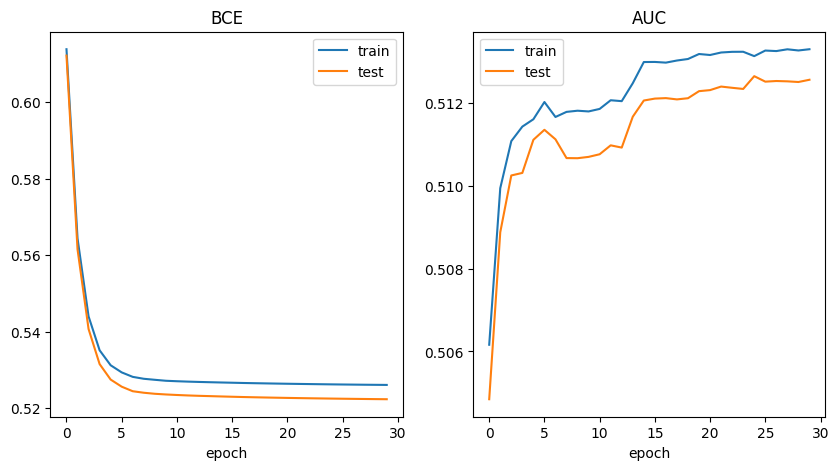

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("BCE")
plot_learning_curves(history["BCE_train"], history["BCE_test"])

plt.subplot(122)
plt.title("AUC")
plot_learning_curves(history["AUC_train"], history["AUC_test"])

plt.show()

Even though the model has not achieved any acceptable results, the graphs show that the model is learning.

**Note** the fact, that train loss has worse results than the test loss confuses me. There is no visible issues in training or logging process.

## Parameters tuning

The results of previous experiments led me to believe that the model was too simple to learn the complex relationships in the data. So, I decided to try tuning the model's hyperparameters by increasing the RNN architecture's hidden size and number of layers. I also experimented with the batch size.

In MLFlow corresponding series of runs is logged as `RNN_<hidden_size>_<num_layers>_<batch_size>`.

This section analyzes the results.

In [32]:
tuning_runs = runs_df["tags.mlflow.runName"].str.match(r"^RNN_\d+_\d+_\d+$")
tuning_runs = runs_df.loc[tuning_runs]
runs_results = load_runs_as_df(tuning_runs["run_id"])

The following table contains the best results of the fitting process with respect to hyperparameters. 

In [34]:
best_results = runs_results.groupby(
    ["num_layers", "hidden_size", "batch_size"],
    as_index=False
)[["BCE_train", "BCE_test", "AUC_train", "AUC_test"]].max()
best_results.sort_values("AUC_test", ascending=False)

,num_layers,hidden_size,batch_size,BCE_train,BCE_test,AUC_train,AUC_test
10,2,30,32,0.532302,0.528405,0.524612,0.524149
16,3,30,32,0.531033,0.527485,0.524833,0.523957
6,2,15,32,0.557332,0.554466,0.524175,0.523845
14,3,20,32,0.543209,0.539928,0.524243,0.523656
8,2,20,32,0.541221,0.537687,0.524125,0.523564
0,1,15,32,0.567292,0.564304,0.523847,0.523390
4,1,30,32,0.534334,0.531278,0.524039,0.523375
12,3,15,32,0.548173,0.545441,0.524001,0.523160
2,1,20,32,0.548336,0.545041,0.524206,0.523032
11,2,30,64,0.541895,0.538766,0.514658,0.514078


The following cell visualizes the relationship between the test's AUC and the different parameters that were tuned.

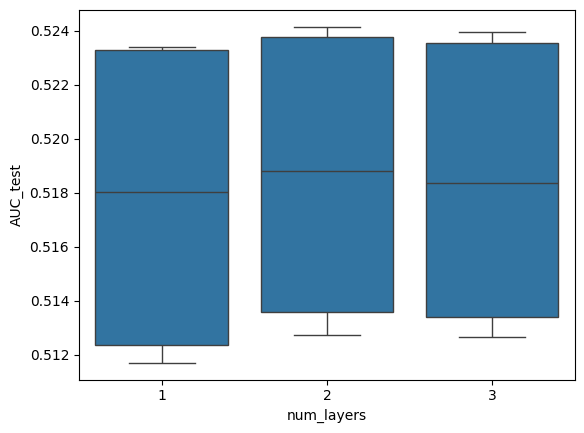

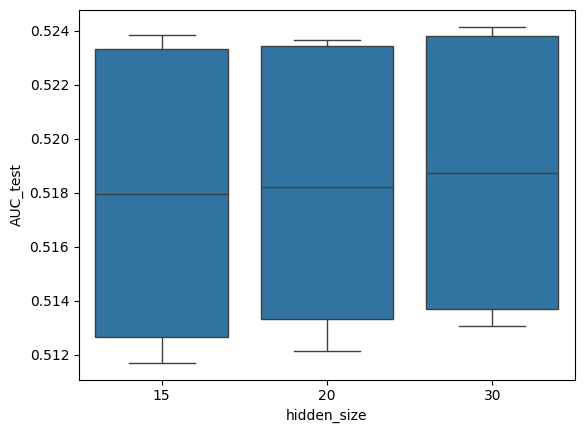

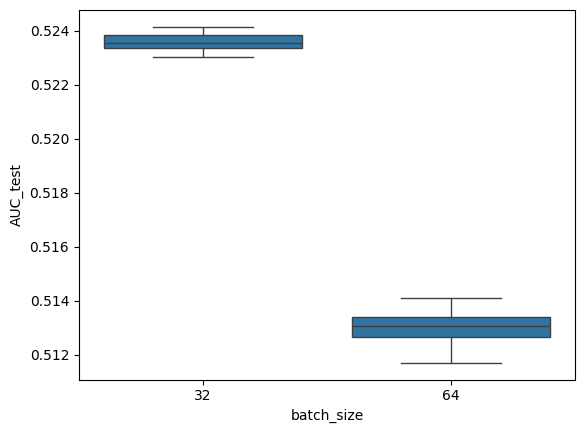

In [35]:
def plot_scatter(var_name):
    plt.figure()
    sns.boxplot(data=best_results, x=var_name, y="AUC_test")

plot_scatter("num_layers")
plot_scatter("hidden_size")
plot_scatter("batch_size")

The number of layers and hidden size doesn't seriously influence on the result, but the batch size does. Smaller batch produces the better results.

### Abusing batch size

The following series of experiments uses batch size to achieve better results.

The next cell loads the logs of the sets of runs with gradually decreasing batch size.

In [62]:
bs_runs = runs_df["tags.mlflow.runName"].str.match(r"^RNN_bs\d+$")
bs_runs = load_runs_as_df(runs_df.loc[bs_runs, "run_id"])
bs_runs["batch_size"] = bs_runs["batch_size"].astype('int')
bs_runs.groupby("batch_size")[["AUC_test"]].max().sort_index()

,AUC_test
batch_size,
4,0.574778
8,0.559036
16,0.538683


The model with the smallest possible batch size have bitten all previous models.

## Transformers

Since RNN experiments did not produce really good models, the next run will explore transformer ecoder to fully connected architecture.

In [74]:
run_id = runs_df.loc[
    runs_df["tags.mlflow.runName"] == "transformer-baseline",
    "run_id"
].iloc[0]
tr_run_history = load_run_as_df(run_id=run_id)

The follwing cell visualize the learning curves for the transformer model.

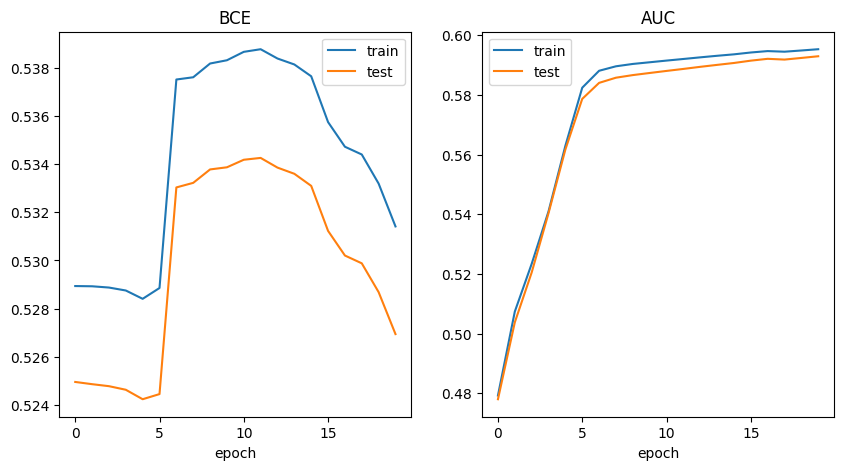

In [75]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("BCE")
plot_learning_curves(tr_run_history["BCE_train"], tr_run_history["BCE_test"])

plt.subplot(122)
plt.title("AUC")
plot_learning_curves(tr_run_history["AUC_train"], tr_run_history["AUC_test"])

plt.show()

Despite the very strange configuration of the loss function value, the AUC increases steadily and reaches the best currently available value.

In [78]:
float(tr_run_history["AUC_test"].max())

0.592957823527578